In [1]:
import os
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

def extract_TESS_photometry(starname,author,nsigma,save_directory,mask_threshold=None):
    '''
    This function is used to extract single sector TESS light curves
    . Currently, 
    this function will only grab the first set of TESS observations
    from the 
    observation tables (search_result object).
    
    Inputs
    ------------------------------------------------------
        starname: Name of the star. Ex: 'TIC 12345678',
        'Proxima Centauri'. Object type: string, str
        author: 'Source of the TESS data. Ex: SPOC,
        TESS-SPOC, QLP'. Object type: string, str 
        nsigma: The number of standard deviations above and below 
        the median of our light curves to remove data from. type: float    
        save_directory: location on computer where figures are saved
        mask_threshold: Input value for aperture selection. 
        type: float or NoneType.
    
    Outputs
    ------------------------------------------------------
        outlier_removed_normalized_bkg_subtracted_lc: a lightkurve object containing
        extracted TESS photometry that is background subtracted, outlier removed and
        then normalized.
    '''
    #Step 0: import libraries we need
    import lightkurve as lk
    import matplotlib.pyplot as plt
    
    # Step 1: Search for TESS images (Target Pixel Files, or tpf)    
    search_result = lk.search_targetpixelfile(starname,author=author)
    
    # recall, MAST has a weird change in their observations table
    # -dataURL ---> dataURI
    # to make sure it's included, let's use a try and except technique    
    try:
        tpf = search_result[0].download(quality_bitmask='hardest',download_dir=save_directory) 
        #will download only first observation [0]
    except KeyError:
        search_result.table['dataURL']  = search_result.table['dataURI']
        tpf = search_result[0].download(quality_bitmask='hardest',download_dir=save_directory)
    
    #Step 2: Perform aperture photometry
    if mask_threshold is None:
        pixel_mask = tpf.pipeline_mask
        background_mask = ~tpf.pipeline_mask
    if mask_threshold is not None:
        pixel_mask = tpf.create_threshold_mask(threshold=mask_threshold)
        background_mask = ~tpf.create_threshold_mask(threshold=mask_threshold)

    lc = tpf.to_lightcurve(aperture_mask=pixel_mask)
    bkg = tpf.to_lightcurve(aperture_mask=background_mask)
    
    #Step 3: Perform Background Subtraction and Normalization
    bkg_subtracted_flux=lc.flux.value - bkg.flux.value
    
    #create new "LightCurve" object
    bkg_subtracted_lc = lk.LightCurve(time=lc.time.value,
                                      flux=bkg_subtracted_flux,
                                      flux_err = lc.flux_err.value)
    
    # normalize the background subtracted light curve
    normalized_bkg_subtracted_lc =  bkg_subtracted_lc.normalize()
    
    outlier_removed_normalized_bkg_subtracted_lc = normalized_bkg_subtracted_lc.remove_outliers(sigma_upper=nsigma)
    
    # Step 4: Visualize the light curve
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)
    
    tpf.plot(aperture_mask=pixel_mask,mask_color='red',
             ax=ax1,show_colorbar=True)
    tpf.plot(aperture_mask=background_mask,mask_color='pink',
             ax=ax1,show_colorbar=False)
    
    
    ax2.set_title(starname+' in Sector '+str(tpf.sector))
    
    ax2.plot(normalized_bkg_subtracted_lc.time.value,
             normalized_bkg_subtracted_lc.flux.value,
           marker='.',color='red',linestyle='none')
    
    ax2.plot(outlier_removed_normalized_bkg_subtracted_lc.time.value,
             outlier_removed_normalized_bkg_subtracted_lc.flux.value,
           marker='.',color='black',linestyle='none')    
  
    ax2.set_xlabel('Time [Days]')
    ax2.set_ylabel('Normalized Relative Flux')
    fig.tight_layout(pad=1)
    plt.savefig(save_directory+starname+'_Sector_'+str(tpf.sector)+'_lightcurve.png',
                bbox_inches='tight')
    plt.show()
    
    return outlier_removed_normalized_bkg_subtracted_lc
    
    
def phasefold_version2(time,flux,flux_err,T0,Period):
    ''' 
    Version 2 is calculating the number of orbital cycles in 
    our light curve but is also shifted so that the phase value
    of 0 is at the T0 reference time.
    Input:
        time: array of timestamps
        flux: array of flux values
        flux_err: array of flux uncertainty values
        T0: float, reference time
        Period: float, orbital period
    Output:
        phase: array of phase values
        flux: array of flux values
        flux_err: array of flux uncertainty values
    '''    
    phase = (time - T0 + 0.5*Period) % Period - 0.5*Period
    ind = np.argsort(phase,axis=0)
    
    return phase[ind], flux[ind], flux_err[ind]
        
def BLS_function(starname, input_lc,
                 min_period,max_period,N_periods,
                 min_dur, max_dur, N_durations,
                 frequency_factor):
    '''
    This function is designed to conduct blind 
    transit searches using the BLS algorithm.
    
    Inputs:
        starname: Name of the star, string
        input_lc: lightkurve object of the input lightcurve, lk.LightCurve
        min_period: minimum period for the blind BLS transit search, floats
        max_period: maximum period for the blind BLS transit search, floats
        N_periods: the number of periods in our period grid, integer
        min_dur: minimum duration for the blind BLS transit search, floats
        max_dur: maximum duration for the blind BLS transit search, floats
        N_durations: the number of periods in our period grid, integer
        frequency_factor: the frequency spacing in between periods 
                          of the power spectrum, integer
    
    Outputs:
       - planet_period: The best-fit orbital period from the 
                        BLS transit search, float
       - planet_t0: The best-fit transit time from the 
                        BLS transit search, float
       - planet_dur: The best-fit transit duration from the 
                        BLS transit search, float
       - figure: a two panel figure showing the BLS power spectrum
                 and the phase-folded light curve on the BLS result, 
                 PNG file
    '''
    
    #step 1: creating period grid for transit searches
    period_grid = np.linspace(min_period,max_period,N_periods)
    duration_grid=np.linspace(min_dur  ,max_dur,N_durations)
    
    #step 2: conducting the blind BLS transit search
    bls = input_lc.to_periodogram(method='bls',
                                  period=period_grid,
                                  duration=duration_grid,
                                  frequency_factor=frequency_factor)
    
    #step 3: plotting BLS power spectra and calculating
    #        BLS Period, T0 and Duration
    
    #plotting power spectram AKA periodogram
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(211)
    ax2=fig.add_subplot(212)
    
    bls.plot(color='black',lw=2,ax=ax1)
    ax1.set_title(starname+' BLS Power Spectrum')
   
    
    # calculating BLS Period, T0 and Duration
    planet_period = bls.period_at_max_power
    planet_t0 = bls.transit_time_at_max_power
    planet_dur = bls.duration_at_max_power
    ax1.axvline(x=planet_period.value,color='red',lw=3,alpha=0.5,zorder=-10)
    print('BLS period is ',planet_period)
    print('BLS reference time is',planet_t0)
    print('BLS duration is',planet_dur)
    print('')
    
    
    # step 4: phasefolding on BLS results
    
    phase, flux, flux_err = phasefold_version2(input_lc.time.value,input_lc.flux.value,input_lc.flux_err.value,
                                               planet_t0.value, planet_period.value)
    
    ax2.plot(phase*24,flux,'k.',markersize=3) #note phase2 x 24 makes phase in units of hours, not days like above
    ax2.set_xlabel('Orbital Phase [Hours since T0]\nzoomed in +/- 3 transit durations')
    ax2.set_ylabel('Normalized Relative Flux')
    ax2.set_xlim(-3.5*planet_dur.value*24,3.5*planet_dur.value*24)
    ax2.axvline(x=0)
    fig.tight_layout(pad=1)
    fig.savefig(starname+'_BLS_result.png',bbox_inches='tight')
    plt.show()
    
    
    return planet_period.value, planet_t0.value, planet_dur.value


def pipeline(starname, author, mask_threshold, nsigma, save_directory,
             min_period,max_period,N_periods,
             min_dur, max_dur, N_durations,
             frequency_factor):
    '''
    This function is used to extract single sector TESS light curves. 
    Currently, this function will only grab the first set of TESS 
    observations from the observation tables (search_result object). 
    After photometry extraction, this code will then conduct blind 
    transit searches using the BLS algorithm.
    
    Inputs
    ------------------------------------------------------
        starname: Name of the star. Ex: 'TIC 12345678',
        'Proxima Centauri'. Object type: string, str
        author: 'Source of the TESS data. Ex: SPOC,
        TESS-SPOC, QLP'. Object type: string, str 
        nsigma: The number of standard deviations above and below 
        the median of our light curves to remove data from. type: float    
        save_directory: location on computer where figures are saved
        mask_threshold: Input value for aperture selection.  type: float or NoneType.
        min_period: minimum period for the blind BLS transit search, floats
        max_period: maximum period for the blind BLS transit search, floats
        N_periods: the number of periods in our period grid, integer
        min_dur: minimum duration for the blind BLS transit search, floats
        max_dur: maximum duration for the blind BLS transit search, floats
        N_durations: the number of periods in our period grid, integer        
        frequency_factor: the frequency spacing in between periods 
                          of the power spectrum, integer
    
    Outputs
    ------------------------------------------------------
        outlier_removed_normalized_bkg_subtracted_lc: a lightkurve object containing
        extracted TESS photometry that is background subtracted, outlier removed and
        then normalized.
        
       - planet_period: The best-fit orbital period from the 
                        BLS transit search, float
       - planet_t0: The best-fit transit time from the 
                        BLS transit search, float
       - planet_dur: The best-fit transit duration from the 
                        BLS transit search, float
       - figure: a two panel figure showing the BLS power spectrum
                 and the phase-folded light curve on the BLS result, 
                 PNG file
    '''
    
    # Step 1: create lightcurve using lightkurve
    outlier_removed_normalized_bkg_subtracted_lc = extract_TESS_photometry(starname=starname,
                                                       author=author,
                                                       mask_threshold=mask_threshold,nsigma=nsigma,
                                                       save_directory=save_directory)
    # Rename output light curve from Step 1:
    input_lc = outlier_removed_normalized_bkg_subtracted_lc
    
    # Step 2: search lightcurve for transits with BLS
    planet_period, planet_t0, planet_dur = BLS_function(starname=starname, input_lc=input_lc,
                                                        min_period=min_period, max_period=max_period, 
                                                        N_periods=N_periods,
                                                        min_dur=min_dur, max_dur=max_dur,N_durations=N_durations,
                                                        frequency_factor=frequency_factor)
    
    
    return input_lc, planet_period, planet_t0, planet_dur    

/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


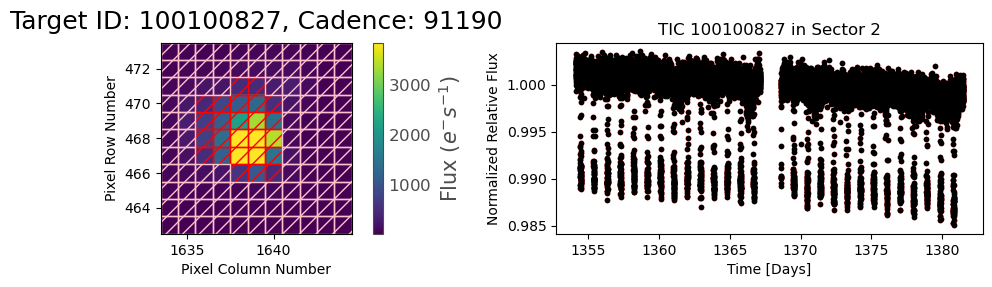

BLS period is  2.8246824682468246 d
BLS reference time is 1355.4015072617192
BLS duration is 0.05 d



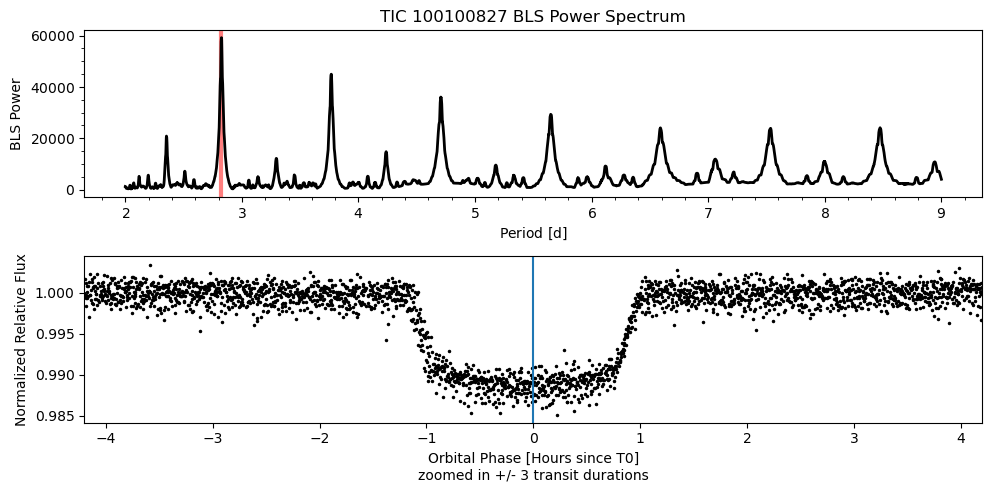


<class 'lightkurve.lightcurve.LightCurve'>


In [2]:
#selecting directoryto save results
import os
savepath = os.getcwd()+'/'
save_directory=savepath

#selecting our target star
starname='TIC 259377017'
author='TESS-SPOC'

# starname='TIC 98796344'
# author='SPOC'

starname='TIC 100100827' #WASP 18
author='SPOC'

#selecting photometry settings
mask_threshold=5
nsigma=2

#selecting period range to search over
min_period=2.
max_period=9
N_periods=10000

#selection duration range to search over
min_dur=0.05
max_dur=1
N_dur=10

frequency_factor=500


output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, 
                                                           mask_threshold, nsigma, 
                                                           save_directory,
                                                           min_period,max_period,N_periods,
                                                           min_dur,max_dur,N_dur,
                                                           frequency_factor)

print('')
print(type(output_lc))

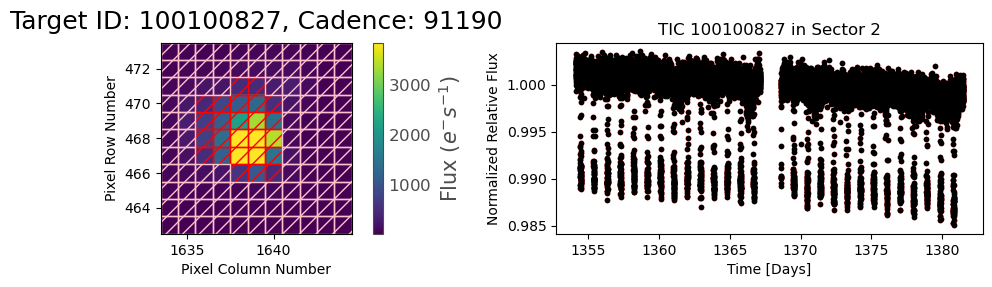

BLS period is  2.8246824682468246 d
BLS reference time is 1355.4015072617192
BLS duration is 0.05 d



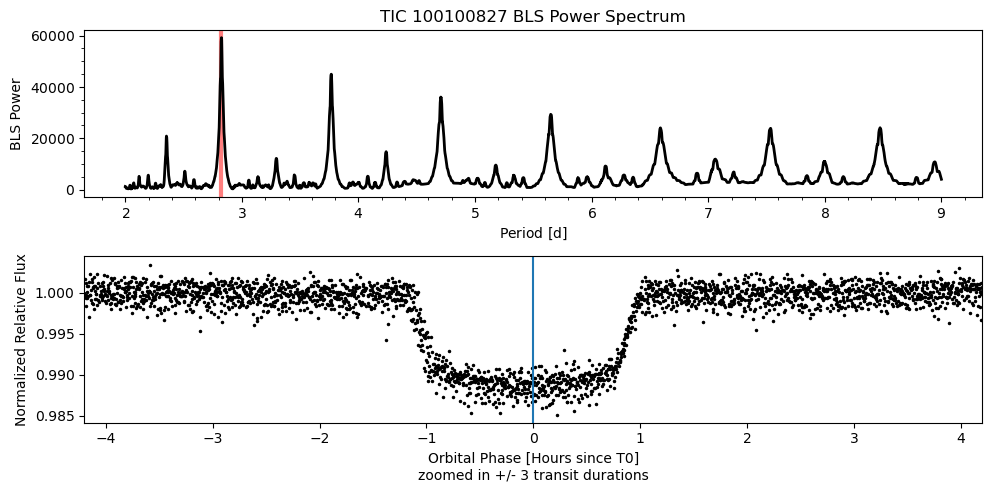

In [3]:
import sys
sys.path.append('/Users/daxfeliz/Downloads/')
from lightcurve_practice_code import pipeline


#selecting directoryto save results
import os
savepath = os.getcwd()+'/'
save_directory=savepath

#selecting our target star
starname='TIC 259377017'
author='TESS-SPOC'

# starname='TIC 98796344'
# author='SPOC'

starname='TIC 100100827' #WASP 18
author='SPOC'

#selecting photometry settings
mask_threshold=5
nsigma=2

#selecting period range to search over
min_period=2.
max_period=9
N_periods=10000

#selection duration range to search over
min_dur=0.05
max_dur=1
N_dur=10

frequency_factor=500


output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, 
                                                           mask_threshold, nsigma, 
                                                           save_directory,
                                                           min_period,max_period,N_periods,
                                                           min_dur,max_dur,N_dur,
                                                           frequency_factor)